In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

In [3]:
# define state schema
class ReflectionState(TypedDict):
    messages: Annotated[list, "Conversation history"]
    iteration: int
    max_iterations: int

In [4]:
llm = ChatOllama(model="llama3.2", temperature=0.7)

In [5]:
# define nodes
def generate_answer(state: ReflectionState) -> ReflectionState:
    """Generate an initial answer or improved answer"""
    response = llm.invoke(state["messages"])
    return {
        "messages": state["messages"] + [response],
        "iteration": state["iteration"]
    }

def reflect_on_answer(state: ReflectionState) -> ReflectionState:
    """Critique the last answer and suggest improvements"""
    last_answer = state["messages"][-1].content

    reflection_prompt = ChatPromptTemplate.from_messages([
        (
            "system", """You are a technical reviewer."""
        ),
    ("human", 
     """Review this answer and provide critique.

     Answer:
     {answer}

     Provide specific suggestions for improvement. Be critical but constructive.
     """)
])
    messages = reflection_prompt.format_messages(
        answer=last_answer
    )

    critique = llm.invoke(messages)

    return {
        "messages": state["messages"] + [
            SystemMessage(content=f"Critique: {critique.content}")
        ],
        "iteration": state["iteration"] + 1
    }

def should_continue(state: ReflectionState) -> str:
    """Decide whether to continue reflecting or end"""
    if state["iteration"] >= state["max_iterations"]:
        return "end"
    return "reflect"

In [6]:
#build graph
workflow = StateGraph(ReflectionState)

# add nodes
workflow.add_node("generate", generate_answer)
workflow.add_node("reflect", reflect_on_answer)

# set entry point
workflow.set_entry_point("generate")

# add edges
workflow.add_conditional_edges(
    "generate",
    should_continue,
    {
        "reflect": "reflect",
        "end": END
    }
)
workflow.add_edge("reflect", "generate")

graph = workflow.compile()

In [7]:
from IPython.display import Image, display

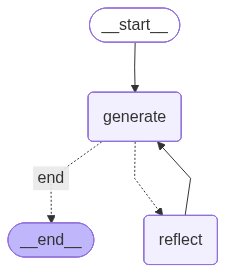

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
result = graph.invoke({
    "messages": [HumanMessage(content="Explain quantum computing to a 10-year-old")],
    "iteration": 0,
    "max_iterations": 2
})

In [10]:
for i, msg in enumerate(result["messages"]):
    print(f"\n{'='*60}")
    print(f"Message {i+1} ({type(msg).__name__}):")
    print(msg.content)


Message 1 (HumanMessage):
Explain quantum computing to a 10-year-old

Message 2 (AIMessage):
Imagine you have a huge box of different colored balls, and each ball represents a possible answer to a question. A regular computer would look at each ball one by one, try to figure out which color it is, and then give an answer.

But a quantum computer is like a magic box that can look at ALL the balls at the same time! It's like having a special power that lets it see all the colors in the box simultaneously. This means it can solve problems way faster than a regular computer, even for really big problems.

Here's how it works: Quantum computers use tiny particles called qubits (quantum bits) to store information. These qubits are super special because they can be in many states at the same time - like being both red AND blue! It's like having a ball that can be two colors at once!

When you put these qubits together, they start to dance and interact with each other in really cool ways. Thi

In [ ]:
from langgraph.graph import MessageGraph